# Resolved-rate control of the end-effector

The goal of this and the next laboratory is to implement a resolved-rate controller to control the end-effector. You should aim to at least finish Part 1 during Lab 5 and Part 2 during Lab 6. We recommend that you read all the instructions in Part 2 well before Lab 6.

Last laboratory, we used analytic IK to compute desired positions for the joint angles that would ensure we reach a desired position (touching the pink balls). Then we generated a straight line trajectory in joint space and used the joint PD controller to track this trajectory.

Here, we will use the fact that $$\mathcal{V}_{SO}^O = J_O(\boldsymbol{\theta}) \cdot \dot{\boldsymbol{\theta}}$$ 
to derive directly a controller acting in the end-effector space,
where $\boldsymbol{\theta} = [\theta_0, \theta_1, \theta_2]$ is the vector containing all the joint positions and $J_O$ is the Jacobian used to compute twists in Frame 0.

## Instructions
Answer all the questions below and submit a pdf with detailed answers to these questions, including the plots through Brightspace. You will also need to submit the Jupyter notebooks with the code used to answer the questions.

## Robot model
Consider the following kinematic model of the robot <img src="./3d_robot_model.png" width="700">


In [1]:
#setup nice plotting
%matplotlib notebook

# we import useful libraries
import time
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt

# we import the robot class
use_real_robot = False

if use_real_robot:
    from nyu_finger import NYUFingerReal    
else:
    from nyu_finger_simulator import NYUFingerSimulator
    
    
# here we define the global variables for the robot size
l0 = 0.3
l1 = 0.16
l2 = 0.16
l3 = 0.014

pybullet build time: Aug 21 2022 18:46:39


In [2]:
# Import needed previously defined functions
def translate(vector): # vector: np.array([1,2,3])
    transform = np.eye(4)
    transform[:3,3:] = vector.reshape(3,1)
    return transform


def rotateX(angle):
    transform = np.eye(4)
    transform[1:3, 1:3] = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    return transform


def rotateY(angle):
    transform = np.eye(4)
    transform[:3, :3] = np.array([[np.cos(angle), 0, np.sin(angle)], [0,1,0], [-np.sin(angle), 0, np.cos(angle)]])
    return transform


def rotateZ(angle):
    transform = np.eye(4)
    transform[:2, :2] = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    return transform


def forward_kinematics(theta):
    # assume theta is a vector, theta[0] = theta0, theta[1] = theta1, etc.
    # we define the lengths of the robot
#     l0 = 0.3
#     l1 = 0.16
#     l2 = 0.16
#     l3 = 0.014

    T_SH1 = translate(np.array([l0, 0, 0]))
    T_H1H2 = rotateX(theta[0]) @ translate(np.array([0, 0, l3])) @ rotateZ(theta[1])
    T_H2K = translate(np.array([0, -l1, 0])) @ rotateZ(theta[2])
    T_KF = translate(np.array([0, -l2, 0]))
    
    T_SF = T_SH1 @ T_H1H2 @ T_H2K @ T_KF
    
    return T_SF


def adjoint(T):
    ''' Gives the adjoint(6x6) of a transformation matrix'''
    AdT = np.zeros((6,6))
    R = T[:3, :3]
    p = T[:3, 3]
    AdT[:3, :3] = R
    AdT[3:6, 3:6] = R
    AdT[3:6, :3] = vec2skewsym(p) @ R
    return AdT


def vec2skewsym(array):
    ''' Bracket notation'''
    a_skew = np.zeros((3,3))
    a_skew[2][1], a_skew[1][2] = array[0], -array[0]
    a_skew[0][2], a_skew[2][0] = array[1], -array[1]
    a_skew[1][0], a_skew[0][1] = array[2], -array[2]
    return a_skew


def get_only_IK(x,y):
    '''
    Input: (x,y) position of the fingertip
    Output: one of theta answers (max 1,3)
    '''
    # Use the first solution, account for no solution
    q_theta = inverse_kinematics(x,y)
    if len(q_theta) != 0:
        return np.array(q_theta[0])
    
    
def inverse_kinematics(x,y):
    """
    inverse kinematics function
    input (x,y) position of the fingertip
    output a list of 3D vectors which are possible solutions to the problem 
    (the list is empty if there are no solutions)
    """
    sol = []
    l_sq = (x - l0) ** 2 + y ** 2
    l_max_sq = (l1 + l2) ** 2
    beta = np.arctan2(y,x-l0)
    theta1 = np.pi/2 + beta
    
    if l_sq > l_max_sq:
        pass
    
    elif l_sq == l_max_sq:
        sol.append([0, theta1, 0])
        
    else:
        alpha = np.arccos((l_sq + l1**2 - l2**2) / (2 * l1 * np.sqrt(l_sq)))
        theta1_p = theta1 - alpha
        theta2_p = np.arccos((l_sq - l1**2 - l2**2) / (2 * l1 * l2))
        sol.append([0, theta1_p, theta2_p])
        
        theta1_n = theta1 + alpha
        theta2_n = - theta2_p
        sol.append([0, theta1_n, theta2_n])
    
    return sol
    # return a list of solutions [[theta0, theta1, theta2]]
    
    
def compute_trajectory(position_init, position_goal, t_init, t_goal, t):
    ''' Parameter can be angle or coordinates, 5th order'''
    T = t_goal - t_init
    dt = t - t_init
    dpos = position_goal - position_init
    pos_param = 10 * (dt / T) ** 3 - 15 * (dt / T) ** 4 + 6 * (dt / T) ** 5
    vel_param = (30 * (dt / T) ** 2 - 60 * (dt / T) ** 3 + 30 * (dt / T) ** 4) / T
    desired_position = position_init + pos_param * dpos
    desired_velocity = vel_param * dpos
    
    # we return the answer
    return desired_position, desired_velocity

# Part 1: compute the end-effector Jacobian

1. Write a ``compute_jacobian`` function which computes the Jacobian of the end-effector. The computed Jacobian should be with respect to a frame located at the end-effector but oriented like the spatial frame (Frame O in the figure above). You will need to reuse the kinematics functions written in the previous laboratories.

Here make sure to return a 6x3 matrix (you will take the rows corresponding to the linear velocity in the following questions).

2. To test your Jacobian function, use your code from Lab 4 that makes the robot reach 3 different goals and compute the velocity of the end-effector at each instant of time. Compare the computed velocities with the velocities you get by numerically differentiating the end-effector positions (i.e. by computing $v[t] = \frac{x[t] - x[t-1]}{\Delta t}$). 

Here you will ignore the angular velocity and only consider the linear velocity of the end-effector. If we only look at the linear velocity of point O (i.e. the velocity of the end-effector with respect to frame O), we can decompose the Jacobian into two part (the top 3 rows are associated to the angular velocity of the end-effector and the bottom 3 are associated to the linear velocity): $$J_O(\boldsymbol{\theta}) = \begin{bmatrix} J_{O\omega} \\ J_{Ov} \end{bmatrix}$$
and we can write the velocity equation as
$$\mathcal{V}_{SO}^O = \begin{pmatrix} \omega_O \\ v_O \end{pmatrix} = \begin{bmatrix} J_{O\omega} \\ J_{Ov} \end{bmatrix} \cdot \dot{\boldsymbol{\theta}}$$

So the linear velocity of the end-effector is $$v_O = J_{Ov} \dot{\boldsymbol{\theta}}$$


3. Plot the velocities computed in question 2.

In [3]:
def compute_jacobian(theta):
    J = np.zeros([3,3])

    # First, we can calculate Jacobian in spacial frame
    T_SH1 = translate(np.array([l0, 0, 0]))
    T_H1H2 = rotateX(theta[0]) @ translate(np.array([0, 0, l3])) @ rotateZ(theta[1])
    T_H2K = translate(np.array([0, -l1, 0])) @ rotateZ(theta[2])
    T_KF = translate(np.array([0, -l2, 0]))
    

    # Getting Jacobian of each joint and stack horizontally
    w_H1 = np.array([[1,0,0,0,0,0]])
    J1_S = adjoint(T_SH1) @ w_H1.T

    w_H2 = np.array([[0,0,1,0,0,0]])
    J2_S = adjoint(T_SH1 @ T_H1H2) @ w_H2.T
 
    w_K = np.array([[0,0,1,0,0,0]])
    J3_S = adjoint(T_SH1 @ T_H1H2 @ T_H2K) @ w_K.T
    
    J_S = np.hstack([J1_S, J2_S, J3_S])
    
    
    # Get transformation matrix of O in spacial frame
    T_SO = forward_kinematics(theta)
    T_SO[:3, :3] = np.zeros(3)
    T_OS = np.eye(4)
    T_OS[:3, 3] = -T_SO[:3, 3]

    
    # Convert from J_S to J_O
    J_O = np.zeros([3,3])
    J_O = adjoint(T_OS) @ J_S
    
    J = J_O[3:,:]

    return J

# test
compute_jacobian([0,0,0])

array([[ 0.   ,  0.32 ,  0.16 ],
       [-0.014,  0.   ,  0.   ],
       [-0.32 ,  0.   ,  0.   ]])

# Part 2: resolved rate control

## End-effector velocities

In contrast to Lab 4 where we generated trajectories in "joint space", i.e. we had a desired start and goal position for each joint, here we will directly generate trajectories for the end-effector and follow them without ever explicitly computing a desired joint position goal. We will work in "end-effector space".

Because our robot have 3 joints, away from singular configurations, the matrix $J_{Ov}$ (which is 3x3) will be invertible. It means that the joint velocity that achieves a desired end-effector velocity is
$$ \dot{\boldsymbol{\theta}} = J_{Ov}^{-1} v_O$$

## End-effector control

If we have a desired velocity we would like to achieve for the end-effector, we can then directly convert it into a desired velocity for the joints. Then we could use our joint PD controller where we would remove the P part to track this joint space velocity.

Assume we have a reference end-effector trajectory (e.g. coming from our trajectory generator that create smooth trajectories from a starting point to a desired goal with 0 velocities and accelerations at the beginning and end of the trajectories). At each instant of time, we then get $x_{ref}$ and $\dot{x}_{ref}$, the desired position and velocity of the end-effector. Our desired end-effector velocity (which is different from the target) could then be a combination between the reference velocity and an error correction term to make sure we stay on the trajectory
$$v_O = \dot{x}_{ref} + P (x_{ref} - x_{measured})$$

and so the desired joint velocities would be
$$\dot{\boldsymbol{\theta}}_{des} = J_{Ov}^{-1} \left( \dot{x}_{ref} + P (x_{ref} - x_{measured}) \right)$$

and the command sent to the robot
$$\tau = D(\dot{\boldsymbol{\theta}}_{des} - \dot{\boldsymbol{\theta}}_{measured})$$

where D is the gain we used in our previous lab for the PD control (the P in the PD controller being canceled).

## Dealing with singularities (very important!!)

The Jacobian becomes singular, i.e. non invertible, when $\theta_2 = 0$. In this case, our control law will not be well defined because the Jacobian cannot be inverted (we will see in class how to deal with this situation too later).

For now, there are 2 simple ways to handle this situation:
1. make sure the robot never reaches a singular configuration, whenever $|\theta_2| < 0.05$ stop everything,
or,
2. when $|\theta_2| < 0.05$ (i.e. we are close to a singularity), we can change the matrix to inverse to make it invertible by replacing $J_{Ov}^{-1}$ by $(J_{Ov} + \epsilon I)^{-1}$ where $\epsilon$ is a small number, e.g. 10e-4.

## Question 1: goal-reaching
1. Write a resolved-rate controller that solves the goal-reaching tasks from Lab 3 and 4 - generate end-effector trajectories using a 5th order polynomial as in Lab 4.
2. Compare the results with the results from Lab 4 - how does the end-effector trajectory change? Plot the measured end-effector position and velocity of the end-effector and the reference ones. The quantities should be graphed vs. time (use the Jacobian to get the measured end-effector velocities)
3. Run the experiment on the real robot and analyze the results.

## Question 2: other movements
1. Write a controller that can draw a circle in the x-y plane. We would like to follow the 3D end-effector trajectory $$x_{ref}(t) = \begin{pmatrix} 0.3 + 0.05\cos(\omega t) \\ -0.2 + 0.05 \sin(\omega t) \\ 0 \end{pmatrix}$$
where $\omega = \pi$ is the frequency of rotation around the circle (frequency of rotation of $0.5Hz$).
2. Plot the measured end-effector position and velocity of the end-effector and the reference ones. The quantities should be graphed vs. time (use the Jacobian to get the measured end-effector velocities)
3. Test the controller(s) on the real robot and plot the same plots as for the simulation
4. Now write a controller that can do a "figure 8" in the x-y plan $$x_{ref}(t) = \begin{pmatrix} 0.35 + 0.08\sin(\omega t) \\ -0.15 + 0.08 \cos(\omega t) \sin(\omega t) \\ 0 \end{pmatrix}$$. Show the same plots as in the previous questions.
5. Write a controller that can do a circle in the x-z plane.

In [4]:
if use_real_robot:
    # Triggers the real robot
    # Don't forget to turn on the robot first !!!
    robot = NYUFingerReal()
    # Make sure that the motor number matches that on the robot
    motor_number = np.array([1,2,0])
    robot.initialize('ens1', motor_number)
else:
    # we can now create a robot simulation
    robot = NYUFingerSimulator()

# we reset the simulation
if not use_real_robot:
    robot.reset_state([0,0,0])

    
# we simulate for 15 seconds (5 seconds per goal)
run_time = 30
dt = 0.001
num_steps = int(run_time/dt)

# the PD gains
# P = np.array([80,80,80])  # Real Robot
P = np.array([50,50,50])   # Simulation
D = np.array([0.05, 0.05, 0.05])

## we allocate a few vectors to collect data while we do the simulation
# we will store the sensor values (angular position and velocities)
measured_positions = np.zeros([num_steps,3])
measured_velocities = np.zeros_like(measured_positions)
# we will store the commands sent to the robot
desired_torques = np.zeros_like(measured_positions)
# we will store the desired joint trajectories that the PD controller follows
desired_positions = np.zeros_like(measured_positions)
desired_velocities = np.zeros_like(measured_positions)
# we keep track of time
time = np.zeros([num_steps])
# we will store the end effector position (desired and measured)
measured_finger_positions = np.zeros([num_steps,3])
measured_finger_velocities = np.zeros([num_steps,3])
desired_finger_positions = np.zeros([num_steps,3])
desired_finger_velocities = np.zeros([num_steps,3])

# here we create a list of ball positions and display them
ball_positions = [np.array([0.4,-0.056, 0.02]), np.array([0.521,-0.1, 0.02]), np.array([0.2,-0.225, 0.02])]
if not use_real_robot:
    for ball in ball_positions:
        robot.add_ball(ball[0], ball[1])
else:
    # we wait
    for i in range(7500):
        robot.send_joint_torque(np.zeros([3,1]))
        robot.step()

# the time to reach a goal
time_to_goal = 10.0

# we use this to know which target we are currently aiming
ball_number = 0

# we measure the internal time for one target movement
t = 0.

'''Initialize all goals'''
start_pos = np.array([l0, -(l1 + l2), 0])
goals = [start_pos] + ball_positions

'''Identify question number - 0: Goal Reaching; 1: Circle; 2: '8' figure '''
question = 2

for i in range(num_steps):
    # get the current time and save it
    time[i] = dt * i
    
    # we read the position and velocities of the joints from the robot or simulation
    q, dq = robot.get_state()
    
    # we store these values for later use
    measured_positions[i,:] = q     #angle
    measured_velocities[i,:] = dq   #angle
    
    # save the current position of the fingertip using the FK function
    pose = forward_kinematics(q)
    measured_finger_positions[i,:] = pose[0:3,3]  #coord
    if i > 0: # Get rid of first iter
        measured_finger_velocities[i,:] = (measured_finger_positions[i,:] - measured_finger_positions[i-1,:])/dt
    
    # controller: TODO HERE IMPLEMENT YOUR CONTROLLER TO REACH ALL 3 TARGETS
    # the goal here is to compute q_des and dq_des that the PD controller will follow
    # you will need some internal logic to decide which ball you are currently targetting, etc.
    
    '''Obtain reference data'''
    # Goal reaching
    if question == 0:
        # Identify the start and end time for each path
        cur_path = int(time[i] // time_to_goal)
        t_init = cur_path * time_to_goal
        t_goal = (cur_path + 1) * time_to_goal

        # Identify the start and end coordinates/angles for each path
        start_coord = goals[cur_path]
        end_coord = goals[cur_path+1]

        x_ref, dx_ref = compute_trajectory(start_coord, end_coord, t_init, t_goal, time[i])
    
    # Circle
    elif question == 1:
        omega = np.pi
        start_coord = np.array([l0, -(l1 + l2), 0])
        end_coord = np.array([0.3 + 0.05 * np.cos(omega * time_to_goal),
                             -0.2 + 0.05 * np.sin(omega * time_to_goal),
                              0])
        
        # Take 10 sec to reach circle path
        if time[i] < time_to_goal:
            x_ref, dx_ref = compute_trajectory(start_coord, end_coord, 0, time_to_goal, time[i])
        
        # Draw circle
        else:
            x_ref = [0.3 + 0.05 * np.cos(omega * time[i]),
                    -0.2 + 0.05 * np.sin(omega * time[i]),
                     0]

            dx_ref = [-0.05 * omega * np.sin(omega * time[i]),
                      0.05 * omega * np.cos(omega * time[i]),
                      0]
    
    # '8' figure
    elif question == 2:
        omega = np.pi
        start_coord = np.array([l0, -(l1 + l2), 0])
        end_coord = np.array([0.35 + 0.08 * np.sin(omega * time_to_goal),
                             -0.15 + 0.08 * np.cos(omega * time_to_goal) * np.sin(omega * 10),
                              0])
        
        # Take 10 sec to reach 8 path
        if time[i] < time_to_goal:
            x_ref, dx_ref = compute_trajectory(start_coord, end_coord, 0, time_to_goal, time[i])
            
        # Draw 8
        else:
            x_ref = [0.35 + 0.08 * np.sin(omega * time[i]),
                    -0.15 + 0.08 * np.cos(omega * time[i]) * np.sin(omega * time[i]),
                     0]

            dx_ref = [0.08 * omega * np.cos(omega * time[i]),
                      0.08 * omega * np.cos(2 * omega * time[i]),
                      0]
    
    
    ''' Resolved-rate Control'''
    v_des = dx_ref + P * (x_ref - measured_finger_positions[i,:])
    
    # Dealing with singularities
    if abs(q[2]) < 0.05:
        inv_J = np.linalg.inv(compute_jacobian(q) + 1e-4 * np.eye(3))
    else:
        inv_J = np.linalg.inv(compute_jacobian(q))
    dq_des =  inv_J @ v_des.T
    
    # Record desired data
    desired_finger_positions[i, :] = x_ref
    desired_finger_velocities[i, :] = dx_ref
    

#     # change this according to your needs so the robot moves according to your goals
#     q_des = np.array([0, 0, 0])
#     dq_des = np.array([0, 0, 0])
    
    
    # we save the desired positions/velocities for later plotting 
#     desired_positions[i,:] = q_des
#     desired_velocities[i,:] = dq_des
    
#     ##PD controller
#     error = q_des - q # the position error for all the joints (it's a 3D vector)
#     d_error = dq_des-dq # the velocity error for all the joints
#     print(d_error)
    
#     # we compute the desired torques as a PD controller
#     joint_torques = P * error + D * d_error
    '''Change torque expression'''
    joint_torques = D * (dq_des-dq)
    desired_torques[i,:] = joint_torques
    
    # we send them to the robot and do one simulation step
    robot.send_joint_torque(joint_torques)
    robot.step()

<IPython.core.display.Javascript object>


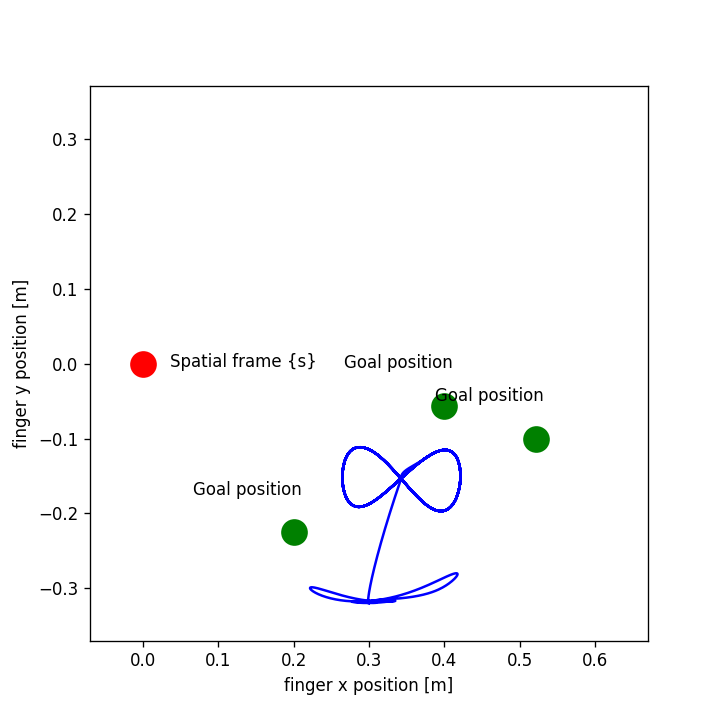

<IPython.core.display.Javascript object>


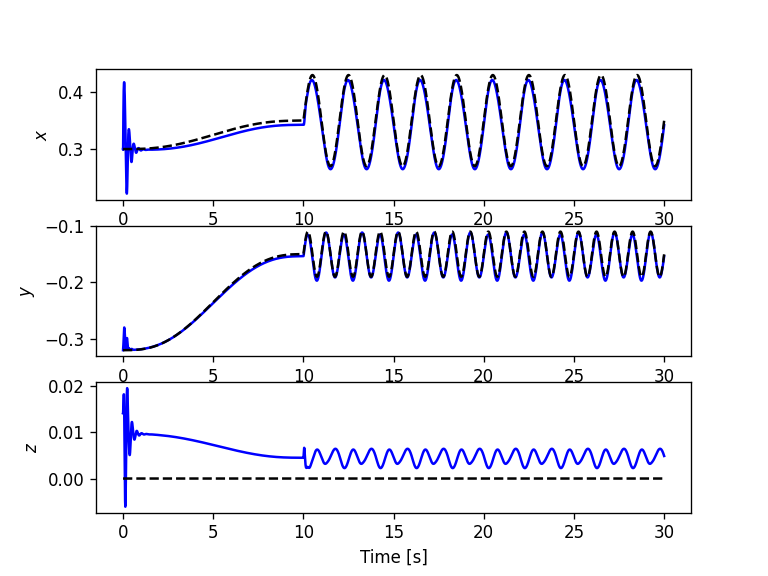

In [5]:
def plot_finger_trajectory(finger_position, ball_positions):
    """
    plots the position of the finger in 2D and the position of the spatial frame {s}
    we assume that the time varying x variable is in x_pos and that the y variable is in y_pos
    """
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    plt.plot(finger_position[:,0],finger_position[:,1], 'b')
    plt.xlabel('finger x position [m]')
    plt.ylabel('finger y position [m]')
    plt.xlim([-l1-l2+l0-0.05,l0+l1+l2+0.05])
    plt.ylim([-l1-l2-0.05, l1+l2+0.05])
    plt.plot([0],[0],'o',markersize=15,color='r')
    
    for ball in ball_positions:
        plt.plot([ball[0]],[ball[1]],'o',markersize=15,color='g')
        ax.annotate('Goal position', xy=(ball[0]-0.2,0.05+ball[1]), xytext=(30,0), textcoords='offset points')
    ax.annotate('Spatial frame {s}', xy=(-0.03,-0.005), xytext=(30,0), textcoords='offset points')
    
    fig = plt.figure()
    
    plt.subplot(3,1,1)
    plt.plot(time, measured_finger_positions[:,0], 'b-', time, desired_finger_positions[:,0], '--k')
    plt.ylabel(r'$x$')
    plt.subplot(3,1,2)
    plt.plot(time, measured_finger_positions[:,1], 'b-', time, desired_finger_positions[:,1], '--k')
    plt.ylabel(r'$y$')
    plt.subplot(3,1,3)
    plt.plot(time, measured_finger_positions[:,2], 'b-', time, desired_finger_positions[:,2], '--k')
    plt.ylabel(r'$z$')
    plt.xlabel('Time [s]')

plot_finger_trajectory(measured_finger_positions, ball_positions)

<IPython.core.display.Javascript object>


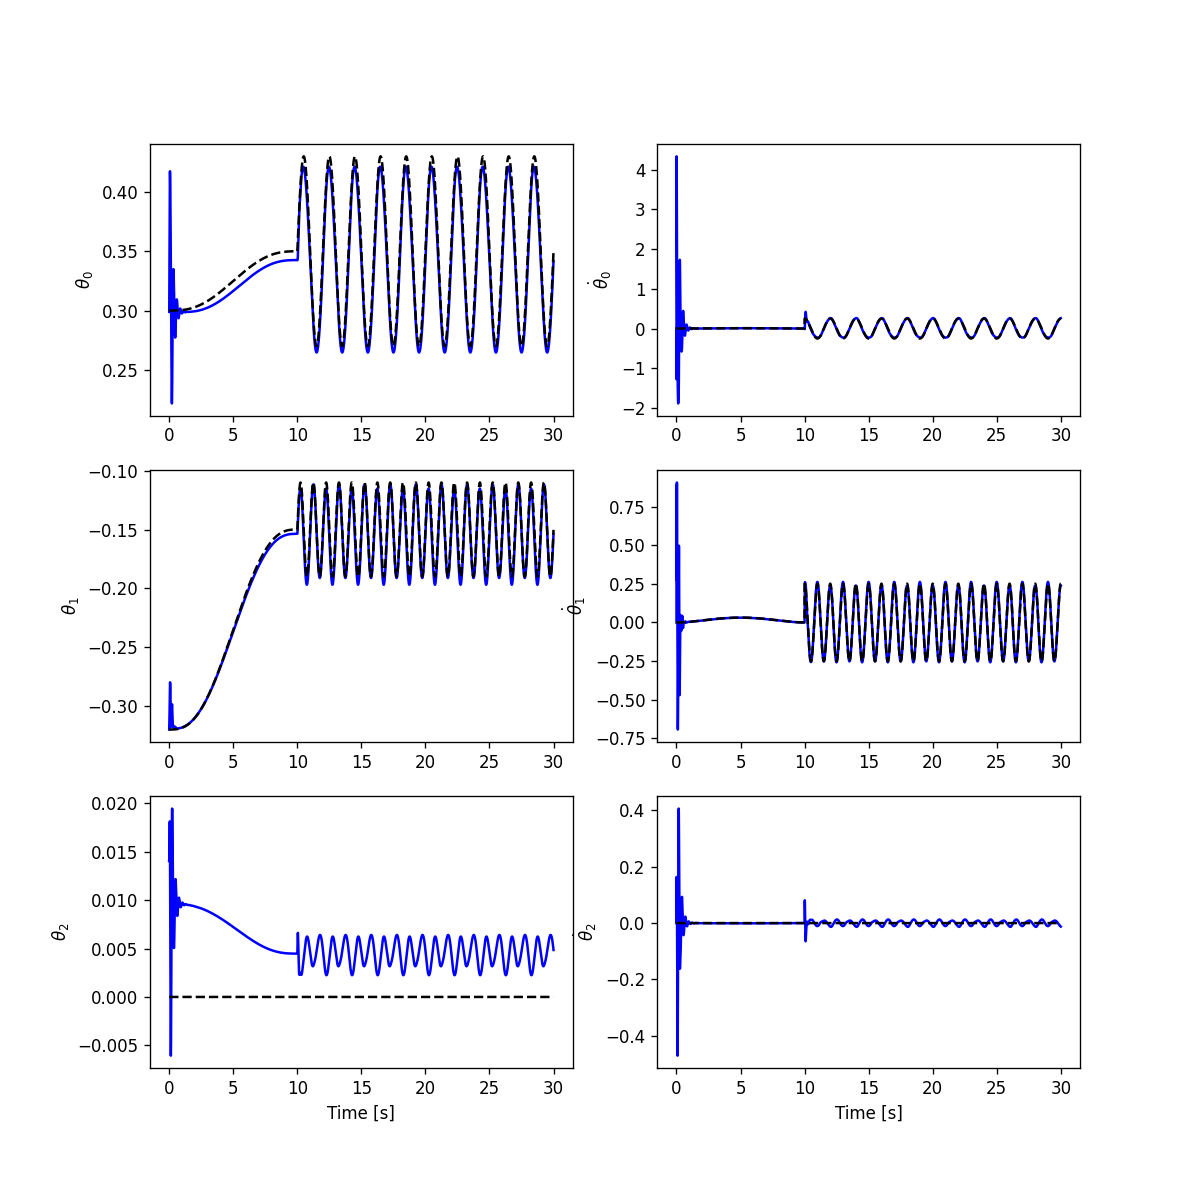

In [6]:
def plot_joint_posvel(time, th, th_des, dth, dth_des):
    fig = plt.figure(figsize=(10,10))
    
    plt.subplot(3,2,1)
    plt.plot(time, th[:,0], 'b-', time, th_des[:,0], '--k')
    plt.ylabel(r'$\theta_0$')
    plt.subplot(3,2,3)
    plt.plot(time, th[:,1], 'b-', time, th_des[:,1], '--k')
    plt.ylabel(r'$\theta_1$')
    plt.subplot(3,2,5)
    plt.plot(time, th[:,2], 'b-', time, th_des[:,2], '--k')
    plt.ylabel(r'$\theta_2$')
    plt.xlabel('Time [s]')
    
    plt.subplot(3,2,2)
    plt.plot(time, dth[:,0], 'b-', time, dth_des[:,0], '--k')
    plt.ylabel(r'$\dot{\theta}_0$')
    plt.subplot(3,2,4)
    plt.plot(time, dth[:,1], 'b-', time, dth_des[:,1], '--k')
    plt.ylabel(r'$\dot{\theta}_1$')
    plt.subplot(3,2,6)
    plt.plot(time, dth[:,2], 'b-', time, dth_des[:,2], '--k')
    plt.ylabel(r'$\dot{\theta}_2$')
    plt.xlabel('Time [s]')
    
plot_joint_posvel(time, measured_finger_positions, desired_finger_positions, measured_finger_velocities, desired_finger_velocities)